Dataset URL: https://www.kaggle.com/datasets/manjeetsingh/retaildataset
License(s): CC0-1.0
  0% 0.00/3.11M [00:00<?, ?B/s]
100% 3.11M/3.11M [00:00<00:00, 591MB/s]
CSV files found: ['/content/stores data-set.csv', '/content/sales data-set.csv', '/content/Features data set.csv', '/content/sample_data/california_housing_train.csv', '/content/sample_data/california_housing_test.csv', '/content/sample_data/mnist_test.csv', '/content/sample_data/mnist_train_small.csv', '/content/stores data-set.csv', '/content/sales data-set.csv', '/content/Features data set.csv']
Loading sales data from: /content/sales data-set.csv
Columns in dataset: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


Using date column: Date
Using sales column: Weekly_Sales
Time series preview:


,Weekly_Sales
Date,
2010-01-10,42239875.87
2010-02-04,50423831.26
2010-02-07,48917484.50
2010-03-09,47194257.61
2010-03-12,49909027.88


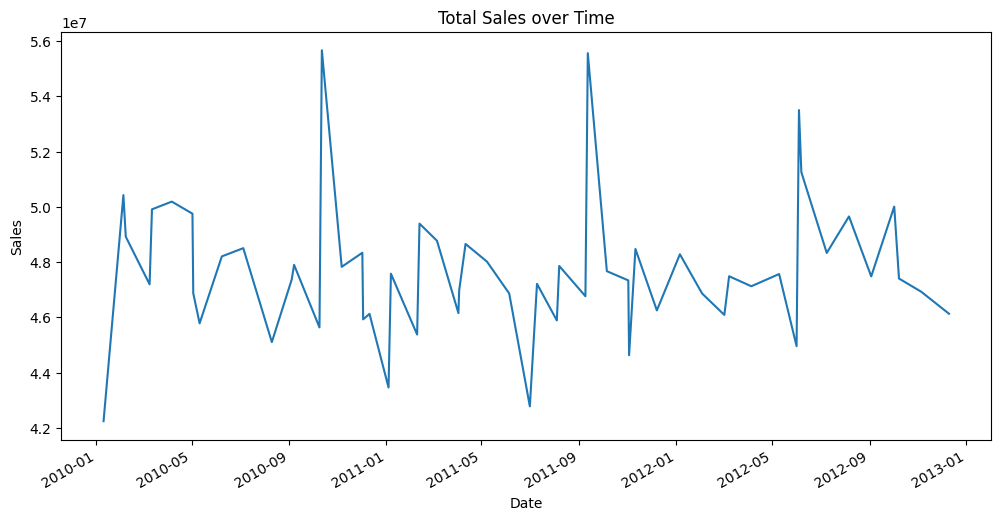

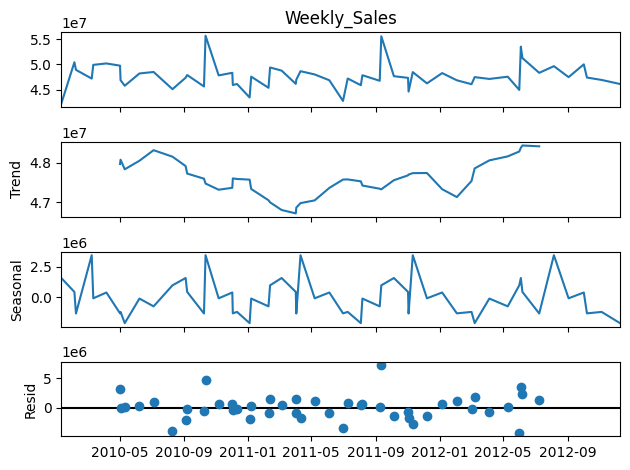

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


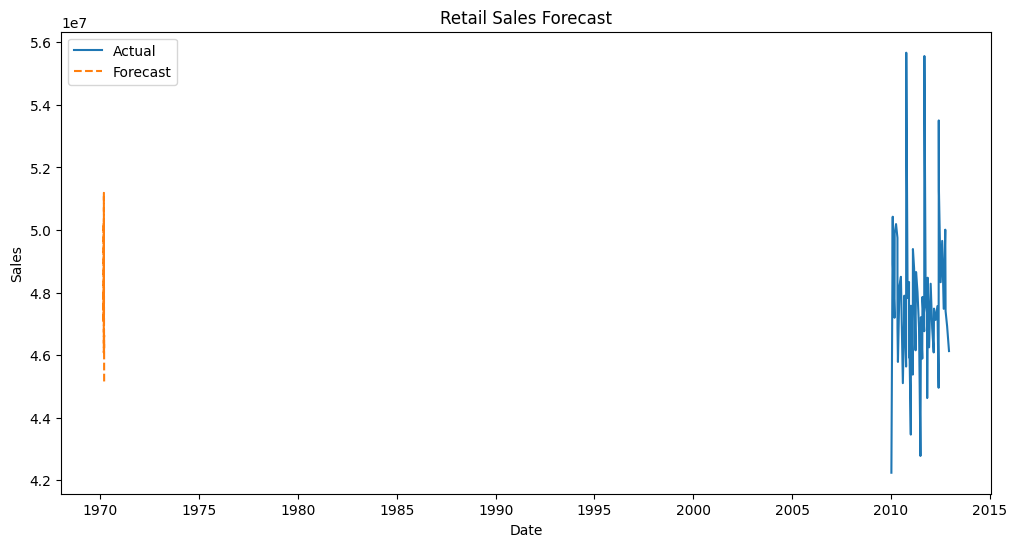

Latest actual sales: 46,128,514.25
Forecast for next period: 48,017,122.58
📦 Inventory level: Maintain or moderate stock — no large spike predicted.


In [3]:
# Install required libraries
!pip install pandas matplotlib statsmodels --quiet

import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# === Step 0: Set Kaggle credentials ===
os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY'

# === Step 1: Download dataset from Kaggle ===
!kaggle datasets download -d manjeetsingh/retaildataset -p /content --unzip

# === Step 2: Inspect downloaded files ===
import glob
csv_files = glob.glob('/content/**/*.csv', recursive=True) + glob.glob('/content/*.csv')
print("CSV files found:", csv_files)

# Automatically detect sales file (contains 'sales' in name)
sales_file = None
for f in csv_files:
    if 'sales' in f.lower():
        sales_file = f
        break

if sales_file is None:
    raise FileNotFoundError("No sales CSV found. Check files:", csv_files)

print("Loading sales data from:", sales_file)
df = pd.read_csv(sales_file, low_memory=False)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# === Step 3: Identify date and sales columns ===
# Look for date-like column
date_col_candidates = [c for c in df.columns if 'date' in c.lower() or 'week' in c.lower()]
if not date_col_candidates:
    raise ValueError("No date-like column found. Columns available: " + ", ".join(df.columns))
date_col = date_col_candidates[0]
print("Using date column:", date_col)

# Look for sales-like column
sales_col_candidates = [c for c in df.columns if 'sales' in c.lower()]
if not sales_col_candidates:
    raise ValueError("No sales-like column found. Columns available: " + ", ".join(df.columns))
sales_col = sales_col_candidates[0]
print("Using sales column:", sales_col)

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col])

# Aggregate sales by date
ts = df.groupby(date_col)[sales_col].sum().sort_index()
print("Time series preview:")
display(ts.head())

# === Step 4: Plot sales over time ===
ts.plot(title='Total Sales over Time', figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# === Step 5: Decompose time series safely ===
# Only perform decomposition if dataset has enough observations
if len(ts) >= 24:  # requires at least 2 cycles for period=12
    period = 12
    decomp = seasonal_decompose(ts, model='additive', period=period)
    decomp.plot()
    plt.tight_layout()
    plt.show()
else:
    print("Dataset too small for seasonal decomposition. Skipping this step.")

# === Step 6: Forecast future sales using Holt-Winters ===
# Holt-Winters works even with small datasets
seasonal_period = min(12, len(ts)//2)  # choose period safely
model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=seasonal_period)
fit = model.fit()
forecast_periods = 12
forecast = fit.forecast(forecast_periods)

# Plot actual + forecast
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('Retail Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# === Step 7: Inventory / Restocking Recommendation ===
latest_actual = ts.iloc[-1]
forecast_next = forecast.iloc[0]
print(f"Latest actual sales: {latest_actual:,.2f}")
print(f"Forecast for next period: {forecast_next:,.2f}")

if forecast_next > latest_actual * 1.2:
    print("⚠️ Recommendation: Increase stock — forecast predicts >20% increase.")
else:
    print("📦 Inventory level: Maintain or moderate stock — no large spike predicted.")